In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [3]:
import os
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Constants
LEARNING_RATE = 0.001
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
NUM_EPOCHS = 30
MODEL = 'vit_base_patch16_224'  # Changed to Vision Transformer
ROOT_DIR = '/content/drive/MyDrive/MEDICAL_DATASET'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure the size matches model requirements
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_datasets = datasets.ImageFolder(root=ROOT_DIR, transform=data_transforms)

# Split the data into training, validation, and test sets
train_data, test_data = train_test_split(image_datasets, test_size=0.2, stratify=image_datasets.targets)
train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=[target for _, target in train_data])

# Data loaders
train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=TEST_BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE)

# Initialize the Vision Transformer model
model = timm.create_model(MODEL, pretrained=True, num_classes=len(image_datasets.classes))
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [4]:
# Training loop
best_val_acc = 0.0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / len(val_loader.dataset))

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {correct / total}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {val_correct / len(val_loader.dataset)}")

    if val_correct / len(val_loader.dataset) > best_val_acc:
        best_val_acc = val_correct / len(val_loader.dataset)
        torch.save(model.state_dict(), "best_vit_model.pth")

    scheduler.step()

# Load the best model
model.load_state_dict(torch.load("best_vit_model.pth"))


Epoch [1/30] Training Loss: 3.167760643362999, Training Accuracy: 0.14682539682539683, Validation Loss: 2.2637106605938504, Validation Accuracy: 0.14285714285714285
Epoch [2/30] Training Loss: 2.1534885108470916, Training Accuracy: 0.15793650793650793, Validation Loss: 2.1175526721136912, Validation Accuracy: 0.1761904761904762
Epoch [3/30] Training Loss: 2.159550964832306, Training Accuracy: 0.15555555555555556, Validation Loss: 2.103066486971719, Validation Accuracy: 0.15714285714285714
Epoch [4/30] Training Loss: 2.132523402571678, Training Accuracy: 0.15793650793650793, Validation Loss: 2.2348210981913974, Validation Accuracy: 0.1738095238095238
Epoch [5/30] Training Loss: 2.160258510708809, Training Accuracy: 0.16825396825396827, Validation Loss: 2.2451040744781494, Validation Accuracy: 0.18333333333333332
Epoch [6/30] Training Loss: 2.0501001060009, Training Accuracy: 0.19603174603174603, Validation Loss: 2.212658064705985, Validation Accuracy: 0.14285714285714285
Epoch [7/30] Tr

<All keys matched successfully>

In [7]:
from itertools import product

Test Accuracy: 0.2619047619047619
Recall: 0.2619047619047619
Precision: 0.2590708459200727
F1 score: 0.24065923465944206
              precision    recall  f1-score   support

     class 0       0.29      0.32      0.30        60
     class 1       0.32      0.10      0.15        60
     class 2       0.20      0.15      0.17        60
     class 3       0.25      0.12      0.16        60
     class 4       0.17      0.17      0.17        60
     class 5       0.32      0.45      0.38        60
     class 6       0.27      0.53      0.36        60

    accuracy                           0.26       420
   macro avg       0.26      0.26      0.24       420
weighted avg       0.26      0.26      0.24       420



NameError: name 'itertools' is not defined

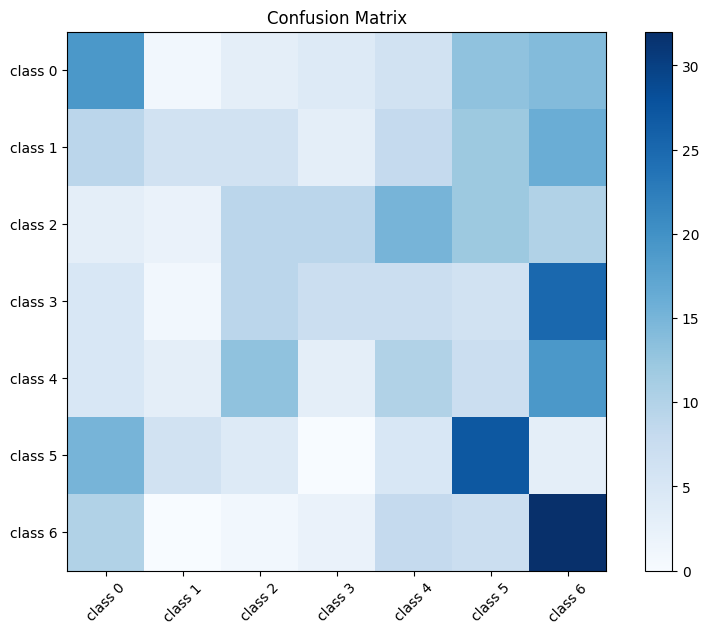

In [8]:
# Test the model
model.eval()
true_labels, pred_labels = [], []
test_correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

test_accuracy = test_correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy}")

# Metrics
recall = recall_score(true_labels, pred_labels, average='macro')
precision = precision_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")

# Classification report
print(classification_report(true_labels, pred_labels, target_names=[f'class {i}' for i in range(len(image_datasets.classes))]))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(image_datasets.classes))
plt.xticks(tick_marks, [f'class {i}' for i in range(len(image_datasets.classes))], rotation=45)
plt.yticks(tick_marks, [f'class {i}' for i in range(len(image_datasets.classes))])
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


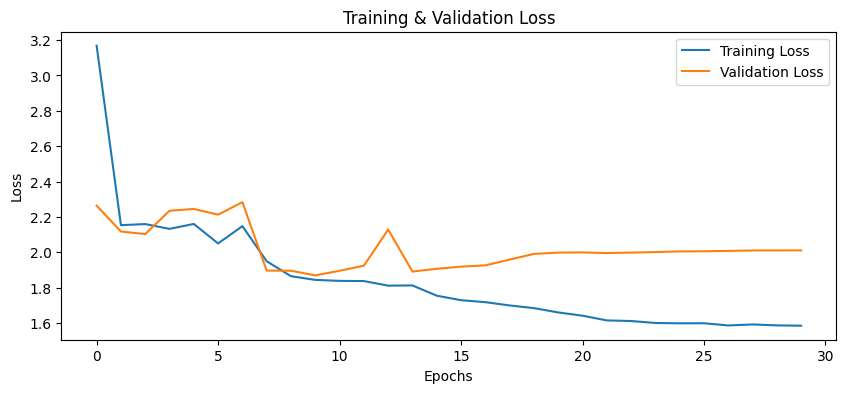

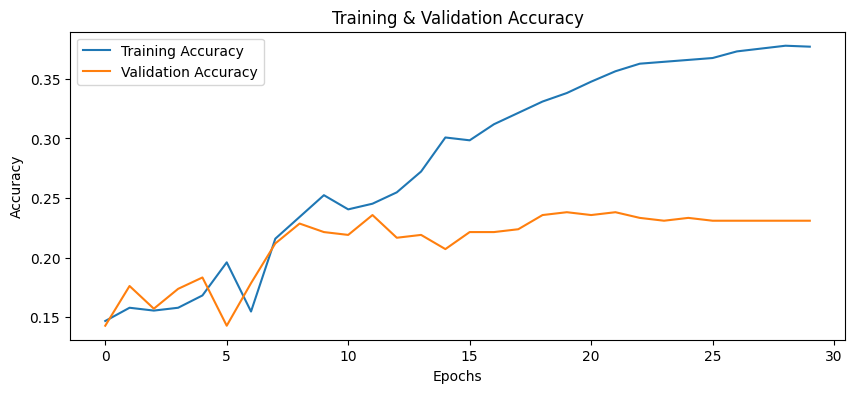

In [6]:
# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()